# Deep Learning &mdash; Assignment 4

Fourth assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2020_

-----

**Names:** Mick Tuit, Maurice Verbrugge

**Group:** 1

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Train and modify a transformer network
2. Experiment with a translation dataset


## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install d2l 

In [23]:
from d2l import torch as d2l
import math
import numpy as np
import torch
from torch import nn

## 4.1 Transformer

There is a detailed description of the transformer model in chapter 10.3 of the d2l book. In this exercise we will do experiments with variations on this model.

**Run the code from that chapter, to train a transformer model on a English->French toy translation dataset**  
Note: Make sure that you use the pytorch version.

In [24]:
# DONE: your code here
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, query, key, value, valid_len):
        # For self-attention, `query`, `key`, and `value` shape:
        # (`batch_size`, `seq_len`, `dim`), where `seq_len` is the length of
        # input sequence. `valid_len` shape is either (`batch_size`, ) or
        # (`batch_size`, `seq_len`).

        # Project and transpose `query`, `key`, and `value` from
        # (`batch_size`, `seq_len`, `num_hiddens`) to
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)

        if valid_len is not None:
            valid_len = torch.repeat_interleave(valid_len, repeats=self.num_heads, dim=0)

        # For self-attention, `output` shape:
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        output = self.attention(query, key, value, valid_len)

        # `output_concat` shape: (`batch_size`, `seq_len`, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


def transpose_qkv(X, num_heads):
    # Input `X` shape: (`batch_size`, `seq_len`, `num_hiddens`).
    # Output `X` shape:
    # (`batch_size`, `seq_len`, `num_heads`, `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # `X` shape:
    # (`batch_size`, `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # `output` shape:
    # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    return output


def transpose_output(X, num_heads):
    # A reversed version of `transpose_qkv`
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, pw_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, pw_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)


class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                            num_hiddens, num_heads, dropout,
                                            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_len):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_len))
        return self.addnorm2(Y, self.ffn(Y))


class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             dropout, use_bias))

    def forward(self, X, valid_len, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_len)
        return X


class DecoderBlock(nn.Module):
    # `i` means it is the i-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_len = state[0], state[1]
        # `state[2][i]` contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
            valid_len = torch.repeat_interleave(torch.arange(1, seq_len + 1, device=X.device),
                                                batch_size, dim=0)
            # Convert valid_len to 2D
            if valid_len.shape[0]!=X.shape[0]:
                valid_len = valid_len.reshape(-1, X.shape[1])
        else:
            valid_len = None

        X2 = self.attention1(X, key_values, key_values, valid_len)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, env_valid_len, *args):
        return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

loss 0.018, 5018.0 tokens/sec on cpu
Go . => il <unk> !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => je l'ai emporté !


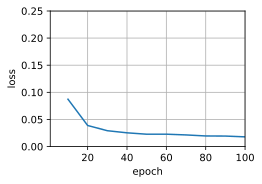

In [25]:
# Train Transformer
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, device)

# Translate a few sentences using the Transformer Model 
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

The example in the book uses a function `d2l.load_data_nmt` to load an English->French translation dataset. This function is implemented in chapter 9.5. This implementation produces only a single iterator over batches of data.

**Modify this function to randomly split the data into a training and test set.**

In [26]:
def load_data_nmt(batch_size, num_steps, train_fraction=0.8, num_examples=1000):
    text = d2l.preprocess_nmt(d2l.read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array(source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = d2l.build_array(target, tgt_vocab, num_steps, False)
    # TODO: modify this code to produce a training and test set
    # Hint: use np.random.permutation
    n_train = int(src_valid_len.shape[0] * train_fraction)
    idxs = np.random.permutation(src_valid_len.shape[0])

    train_data_arrays = (src_array[idxs[:n_train]], src_valid_len[idxs[:n_train]], tgt_array[idxs[:n_train]], tgt_valid_len[:n_train])
    test_data_arrays = (src_array[idxs[n_train:]], src_valid_len[idxs[n_train:]], tgt_array[idxs[n_train:]], tgt_valid_len[n_train:])
    
    train_iter = d2l.load_array(train_data_arrays, batch_size)
    test_iter = d2l.load_array(test_data_arrays, batch_size)

    return src_vocab, tgt_vocab, train_iter, test_iter

With a test set in hand, we can make more informed decisions when comparing different models. The simplest metric to implement is test set loss. Just like in previous weeks, it would be nice to plot the test metrics during training. To do that we will need to modify the `d2l.train_s2s_ch9` function, which is defined in chapter 9.7.

**Complete the implementation below**

In [27]:
def train_s2s(model, train_iter, test_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            legend=['train loss', 'test loss'],
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in train_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1], None))
            test_loss = calculate_test_loss(model, loss, test_iter, device)
            animator.add(epoch, (None, test_loss))
    print(f'train loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'test loss {test_loss:.3f} '
          f'tokens/sec on {str(device)}')

def calculate_test_loss(model, loss, test_iter, device):
    # TODO: your code here
    # Hint: look at the training code
    metric = d2l.Accumulator(2)
    for batch in test_iter: 
        X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
        Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
        Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
        l = loss(Y_hat, Y_label, Y_vlen)
        num_tokens = Y_vlen.sum()
        
        with torch.no_grad():
                metric.add(l.sum(), num_tokens)

    return metric[0]/metric[1]

**Re-train the transformer model, this time showing test set loss. How does this compare to training set loss?**

train loss 0.014, 3570.6 test loss 0.108 tokens/sec on cpu


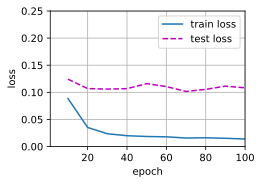

In [28]:
# DONE: your code here

# Train Transformer
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, train_iter, test_iter = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, train_iter, test_iter, lr, num_epochs, device)

## 4.3 Data size

The model is only trained on 1000 sentence pairs. You can change this with the `num_examples` parameter to `load_data_nmt`.
When you do this, note that the code in d2l chapter 10.3 has a bug, where it uses the size of the *source* vocabulary (English in this case) for both the encoder and the decoder. You will run into this when using different amounts of data.

**Train with a larger dataset**

train loss 0.016, 3823.7 test loss 0.125 tokens/sec on cpu


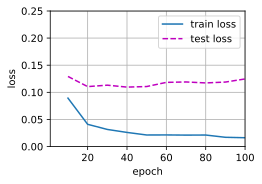

In [29]:
# TODO: your code here

# Train Transformer
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, train_iter, test_iter = load_data_nmt(batch_size, num_steps, num_examples=2000)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, train_iter, test_iter, lr, num_epochs, device)

By taking only the first 1000 samples we have limited ourselves to very simple sentences (see `data/fra.txt`). Later sentences in the dataset are longer.

**Will the code need to be modified to correctly handle these larger sentences?**

DONE: your answer here

No this is not necessary, since the input of the Transformer is a matrix, where each row is a word embdding. A longer sentence simply means that the matrix will contain more rows.

## 4.4 Variations

train loss 0.161, 2591.7 test loss 0.192 tokens/sec on cpu


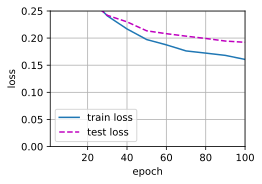

In [30]:
# Train Transformer
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.5, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, train_iter, test_iter = load_data_nmt(batch_size, num_steps, num_examples=2000)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, train_iter, test_iter, lr, num_epochs, device)

**Does dropout improve the test set performance?**

DONE: your answer here

When we set dropout to `dropout = 0.5` we see that loss of train and test are both higher than without dropout. However, we do see that the loss of the test set is decreasing, whereas when using no dropout this loss is remaining the same.

After that we tried `dropout = 0.2` and we see that once again both train and test loss are decreasing. The train loss is not as low as without dropout, however the test set is reaching the same number. 

Using `dropout = 0.8` we don't even see the loss curve in the pot, meaning that it is above 0.25. 

From this we can result that adding dropout is not improving the test set performance, it just needs more epochs to reach the same performance. 

**Change the number of heads in the encoder and/or decoder. Do you see any difference in the results?**

train loss 0.018, 4726.1 test loss 0.132 tokens/sec on cpu


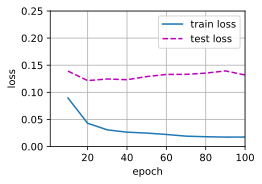

In [31]:
# Train Transformer
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 2
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

src_vocab, tgt_vocab, train_iter, test_iter = load_data_nmt(batch_size, num_steps, num_examples=2000)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

model = d2l.EncoderDecoder(encoder, decoder)
train_s2s(model, train_iter, test_iter, lr, num_epochs, device)

DONE: your answer here

We first changed heads to `num_heads = 8` in both encoder and decoder, and we saw roughly the same performance as with `num_heads = 4`.

Then we tried `num_heads = 2` for both encoder and decoder and we saw a decrease in the test loss to `loss = 0.092`. 

This means that changing the number of heads can definitely have a difference on the performance. 

**Look at the `MultiHeadAttention` module. Does the number of trainable parameters change with the number of heads? And if so, how?**

DONE: your answer here

Yes, most definitely, since if we increase the number of heads we have seperate Q, K, V weight matrices for each head which result in seperate Q, K, V matrices. These weight matrices can be trained individually. 

**What happens if you don't use any positional encoding? Can you explain why?**

DONE: your answer here

If we don't use positional encoding the model does't have a way to take the sequence of the input into consideration. This is because the output is computed independently and therefore does not model the sequence. It would mean that the sequence of a sentence is not important. However, in language the sequence is important, and therefore we need positional encoding. 

**What happens if you change only one of the `key_size`, `query_size` or `value_size`? Can you explain why?**

DONE: your answer here

If we only change of these values, the resulting K, Q or V dimension (based on which value is changed) will differ from the other dimensions. This will mean that the output of the self-attention layer will have a different dimension than the input of the self-attention layer. This is because of the matrix multiplication which happens inside of the attenion layer. 

**Compare the results of the transformer with the LSTM network from d2l chapter 9.7. Discuss the differences**

loss 0.037, 8376.8 tokens/sec on cpu


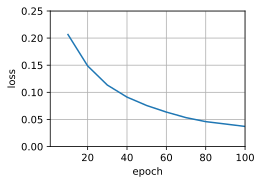

In [32]:
# TODO your code here

#@save
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        # RNN needs first axes to be time step, i.e., seq_len
        X = X.permute(1, 0, 2)
        out, state = self.rnn(X) # When state is not mentioned, it defaults to zeros
        # out shape: (seq_len, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens),
        # where "state" contains the hidden state and the memory cell
        return out, state

#@save
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).permute(1, 0, 2)
        return out, state

#@save
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_len shape: (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0,2,1), label)
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        return weighted_loss

#@save
def train_s2s_ch9(model, data_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')


embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)

train_s2s_ch9(model, train_iter, lr, num_epochs, device)


DONE: your answer here

The loss of the seq2seq model is `0.037`, from the Transformer the lowest loss we have is `0.014`. The Transformer model is outperforming the seq2seq model, however we dont have a test set in this case, so it's hard to tell if it is really outperforming the other model. 

## The end

Well done! Please double check the instructions at the top before you submit your results.